In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import os
import joblib
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
import signal

warnings.filterwarnings('ignore')

import torch
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestRegressor
from cuml.linear_model import LinearRegression, Ridge, Lasso
from cuml.metrics import mean_squared_error as cu_mse

import xgboost as xgb

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException("Training timed out")

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("No GPU available. Consider running on a GPU-enabled environment.")

print("Libraries imported successfully!")

CUDA available: True
GPU Device: Tesla T4
Number of GPUs: 1
Libraries imported successfully!


In [ ]:
print("Reading data from CSV file...")
try:
    df = pd.read_csv("/content/drive/MyDrive/data/mta_1710.csv", on_bad_lines='skip', low_memory=False)
    print(f"Number of records: {len(df)}")
    print(f"Data columns: {df.columns.tolist()}")
except Exception as e:
    print(f"Error reading the CSV file: {e}")
    raise

df = cudf.DataFrame.from_pandas(df)
print("Data converted to GPU DataFrame successfully!")

df = df.rename(columns={
    "VehicleLocation.Latitude": "VehicleLocationLatitude",
    "VehicleLocation.Longitude": "VehicleLocationLongitude"
})

null_counts = df.isnull().sum()
print("Null values in dataset:")
print(null_counts)

numeric_cols = [
    "OriginLat", "OriginLong",
    "VehicleLocationLatitude", "VehicleLocationLongitude",
    "DestinationLat", "DestinationLong",
    "DistanceFromStop"
]

important_cols = ["OriginName", "DestinationName", "NextStopPointName",
                 "VehicleLocationLatitude", "VehicleLocationLongitude", "DistanceFromStop"]

for col_name in numeric_cols:
    if col_name in df.columns:
        df[col_name] = df[col_name].astype('float32')

df_clean = df.dropna(subset=important_cols)


print(f"Number of records after removing null values: {len(df_clean)}")

Reading data from CSV file...
Number of records: 6865376
Data columns: ['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName', 'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat', 'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude', 'VehicleLocation.Longitude', 'NextStopPointName', 'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime', 'ScheduledArrivalTime']
Data converted to GPU DataFrame successfully!
Null values in dataset:
RecordedAtTime                    0
DirectionRef                      0
PublishedLineName                 0
OriginName                    63441
OriginLat                     63441
OriginLong                    63441
DestinationName                   0
DestinationLat                10369
DestinationLong               10369
VehicleRef                        0
VehicleLocationLatitude           0
VehicleLocationLongitude          0
NextStopPointName              7086
ArrivalProximityText           7086
DistanceFromStop   

In [ ]:
df_clean['RecordedAtTime'] = cudf.to_datetime(df_clean['RecordedAtTime'])
df_clean['Hour'] = df_clean['RecordedAtTime'].dt.hour
df_clean['DayOfWeek'] = df_clean['RecordedAtTime'].dt.dayofweek + 1
df_clean['Month'] = df_clean['RecordedAtTime'].dt.month
df_clean['WeekOfYear'] = df_clean['RecordedAtTime'].dt.isocalendar().week

df_clean['DayOfMonth'] = df_clean['RecordedAtTime'].dt.day
df_clean['DayOfYear'] = df_clean['RecordedAtTime'].dt.dayofyear

try:
    df_clean['IsMonthEnd'] = df_clean['RecordedAtTime'].dt.is_month_end.astype('int32')
    df_clean['IsMonthStart'] = df_clean['RecordedAtTime'].dt.is_month_start.astype('int32')
except AttributeError:
    df_clean['IsMonthEnd'] = ((df_clean['DayOfMonth'] >= 28) & (df_clean['DayOfMonth'] <= 31)).astype('int32')
    df_clean['IsMonthStart'] = (df_clean['DayOfMonth'] == 1).astype('int32')

df_clean['IsMorningPeak'] = ((df_clean['Hour'] >= 7) & (df_clean['Hour'] <= 9)).astype('int32')
df_clean['IsEveningPeak'] = ((df_clean['Hour'] >= 16) & (df_clean['Hour'] <= 18)).astype('int32')
df_clean['IsWeekend'] = ((df_clean['DayOfWeek'] == 1) | (df_clean['DayOfWeek'] == 7)).astype('int32')

df_clean['Hour_sin'] = np.sin(2 * np.pi * df_clean['Hour']/24)
df_clean['Hour_cos'] = np.cos(2 * np.pi * df_clean['Hour']/24)
df_clean['DayOfWeek_sin'] = np.sin(2 * np.pi * df_clean['DayOfWeek']/7)
df_clean['DayOfWeek_cos'] = np.cos(2 * np.pi * df_clean['DayOfWeek']/7)
df_clean['Month_sin'] = np.sin(2 * np.pi * df_clean['Month']/12)
df_clean['Month_cos'] = np.cos(2 * np.pi * df_clean['Month']/12)

numeric_features = [
    "OriginLat", "OriginLong",
    "DestinationLat", "DestinationLong",
    "VehicleLocationLatitude", "VehicleLocationLongitude",
    "Hour", "DayOfWeek", "Month", "WeekOfYear",
    "IsMorningPeak", "IsEveningPeak", "IsWeekend",
    "DayOfMonth", "DayOfYear", "IsMonthEnd", "IsMonthStart",
    "Hour_sin", "Hour_cos", "DayOfWeek_sin", "DayOfWeek_cos",
    "Month_sin", "Month_cos"
]

categorical_cols = [
    "PublishedLineName",
    "OriginName",
    "DestinationName",
    "NextStopPointName",
    "DirectionRef"
]

available_features = [col for col in numeric_features if col in df_clean.columns]
print(f"Using features: {available_features}")

label_col = "DistanceFromStop"
X = df_clean[available_features]
y = df_clean[label_col]

for col in available_features:
    mean_val = X[col].mean()
    X[col] = X[col].fillna(mean_val)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

try:
    temp_timestamp = df_clean['RecordedAtTime'].astype('int64')

    temp_df = cudf.DataFrame()
    temp_df['timestamp'] = temp_timestamp
    temp_df['original_index'] = df_clean.index

    sorted_temp_df = temp_df.sort_values('timestamp')

    sorted_indices = sorted_temp_df['original_index'].values_host

    train_size = int(0.7 * len(sorted_indices))
    test_size = int(0.2 * len(sorted_indices))

    train_indices = sorted_indices[:train_size]
    test_indices = sorted_indices[train_size:train_size+test_size]
    val_indices = sorted_indices[train_size+test_size:]

    X_train = X_scaled[train_indices]
    y_train = y[train_indices]

    X_test = X_scaled[test_indices]
    y_test = y[test_indices]

    X_val = X_scaled[val_indices]
    y_val = y[val_indices]

    print("Data split chronologically for time series analysis")
except Exception as e:
    print(f"Error during time-based splitting: {e}")
    print("Falling back to random splitting...")
    # Sử dụng phương pháp chia ngẫu nhiên nếu gặp lỗi
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Validation samples: {len(X_val)}")

Using features: ['OriginLat', 'OriginLong', 'DestinationLat', 'DestinationLong', 'VehicleLocationLatitude', 'VehicleLocationLongitude', 'Hour', 'DayOfWeek', 'Month', 'WeekOfYear', 'IsMorningPeak', 'IsEveningPeak', 'IsWeekend', 'DayOfMonth', 'DayOfYear', 'IsMonthEnd', 'IsMonthStart', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos']
Error during time-based splitting: 665
Falling back to random splitting...
Training samples: 4756422
Test samples: 1365773
Validation samples: 672693


In [ ]:

def calculate_metrics(y_true, y_pred):
    if isinstance(y_true, cudf.Series):
        y_true = y_true.to_pandas().values
    if isinstance(y_pred, cudf.Series) or hasattr(y_pred, 'to_pandas'):
        y_pred = y_pred.to_pandas().values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)


    bins = np.linspace(min(y_true), max(y_true), 5)
    y_true_binned = np.digitize(y_true, bins)
    y_pred_binned = np.digitize(y_pred, bins)

    cm = confusion_matrix(y_true_binned, y_pred_binned)
    return rmse, r2, cm, bins

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest_50": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "RandomForest_100": RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    "RandomForest_200": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    "TimeSeries_RF": RandomForestRegressor(n_estimators=100, max_depth=15,
                                          max_features="sqrt", min_samples_leaf=4,
                                          random_state=42)
}

dtrain = xgb.DMatrix(data=X_train.to_pandas() if hasattr(X_train, 'to_pandas') else X_train,
                     label=y_train.to_pandas() if hasattr(y_train, 'to_pandas') else y_train)
dtest = xgb.DMatrix(data=X_test.to_pandas() if hasattr(X_test, 'to_pandas') else X_test,
                    label=y_test.to_pandas() if hasattr(y_test, 'to_pandas') else y_test)
dval = xgb.DMatrix(data=X_val.to_pandas() if hasattr(X_val, 'to_pandas') else X_val,
                   label=y_val.to_pandas() if hasattr(y_val, 'to_pandas') else y_val)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'gpu_hist'  # Sử dụng GPU
}

results = {}
all_models = {}
confusion_matrices = {}

print("Training and evaluating models...")
for name, model in models.items():
    start_time = time.time()
    try:
        print(f"Training {name} model...")

        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(1800)  # 30 minutes in seconds

        model.fit(X_train, y_train)

        signal.alarm(0)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        val_predictions = model.predict(X_val)

        train_rmse, train_r2, train_cm, _ = calculate_metrics(y_train, train_predictions)
        test_rmse, test_r2, test_cm, cm_bins = calculate_metrics(y_test, test_predictions)
        val_rmse, val_r2, val_cm, _ = calculate_metrics(y_val, val_predictions)

        training_time = time.time() - start_time

        results[name] = {
            "train_rmse": train_rmse,
            "train_r2": train_r2,
            "test_rmse": test_rmse,
            "test_r2": test_r2,
            "val_rmse": val_rmse,
            "val_r2": val_r2,
            "training_time": training_time,
            "predictions": {
                "train": train_predictions,
                "test": test_predictions,
                "val": val_predictions
            }
        }

        all_models[name] = model
        confusion_matrices[name] = (test_cm, cm_bins)

        print(f"  Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
        print(f"  Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
        print(f"  Validation RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
        print(f"  Training time: {training_time:.2f} seconds")

    except TimeoutException:
        print(f"Model {name} training timed out after 30 minutes. Skipping.")
        continue
    except Exception as e:
        print(f"Error training {name} model: {e}")
        continue

try:
    print("Training XGBoost model...")
    start_time = time.time()

    xgb_model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=25
    )

    xgb_train_preds = xgb_model.predict(dtrain)
    xgb_test_preds = xgb_model.predict(dtest)
    xgb_val_preds = xgb_model.predict(dval)

    # Calculate metrics
    xgb_train_rmse, xgb_train_r2, xgb_train_cm, _ = calculate_metrics(
        y_train.to_pandas() if hasattr(y_train, 'to_pandas') else y_train,
        xgb_train_preds
    )
    xgb_test_rmse, xgb_test_r2, xgb_test_cm, xgb_cm_bins = calculate_metrics(
        y_test.to_pandas() if hasattr(y_test, 'to_pandas') else y_test,
        xgb_test_preds
    )
    xgb_val_rmse, xgb_val_r2, xgb_val_cm, _ = calculate_metrics(
        y_val.to_pandas() if hasattr(y_val, 'to_pandas') else y_val,
        xgb_val_preds
    )

    training_time = time.time() - start_time

    results["XGBoost"] = {
        "train_rmse": xgb_train_rmse,
        "train_r2": xgb_train_r2,
        "test_rmse": xgb_test_rmse,
        "test_r2": xgb_test_r2,
        "val_rmse": xgb_val_rmse,
        "val_r2": xgb_val_r2,
        "training_time": training_time,
        "predictions": {
            "train": xgb_train_preds,
            "test": xgb_test_preds,
            "val": xgb_val_preds
        }
    }

    all_models["XGBoost"] = xgb_model
    confusion_matrices["XGBoost"] = (xgb_test_cm, xgb_cm_bins)

    print(f"  XGBoost Train RMSE: {xgb_train_rmse:.4f}, R²: {xgb_train_r2:.4f}")
    print(f"  XGBoost Test RMSE: {xgb_test_rmse:.4f}, R²: {xgb_test_r2:.4f}")
    print(f"  XGBoost Validation RMSE: {xgb_val_rmse:.4f}, R²: {xgb_val_r2:.4f}")
    print(f"  XGBoost Training time: {training_time:.2f} seconds")

except Exception as e:
    print(f"Error training XGBoost model: {e}")

Training and evaluating models...
Training LinearRegression model...
  Train RMSE: 1015.4850, R²: 0.0227
  Test RMSE: 1013.6200, R²: 0.0227
  Validation RMSE: 1028.6210, R²: 0.0226
  Training time: 9.37 seconds
Training Ridge model...
  Train RMSE: 1015.4850, R²: 0.0227
  Test RMSE: 1013.6200, R²: 0.0227
  Validation RMSE: 1028.6210, R²: 0.0226
  Training time: 10.72 seconds
Training Lasso model...
  Train RMSE: 1015.4867, R²: 0.0227
  Test RMSE: 1013.6196, R²: 0.0227
  Validation RMSE: 1028.6235, R²: 0.0225
  Training time: 3.35 seconds
Training RandomForest_50 model...
  Train RMSE: 569.5867, R²: 0.6925
  Test RMSE: 569.0046, R²: 0.6920
  Validation RMSE: 572.0950, R²: 0.6976
  Training time: 32.56 seconds
Training RandomForest_100 model...
  Train RMSE: 392.7716, R²: 0.8538
  Test RMSE: 408.8743, R²: 0.8410
  Validation RMSE: 404.2244, R²: 0.8491
  Training time: 73.33 seconds
Training RandomForest_200 model...
  Train RMSE: 395.3839, R²: 0.8518
  Test RMSE: 410.9352, R²: 0.8394
  V


Creating ensemble of best models...
Top 3 models for ensemble: ['XGBoost', 'RandomForest_100', 'RandomForest_200']
  Ensemble Train RMSE: 337.1842, R²: 0.8923
  Ensemble Test RMSE: 349.3051, R²: 0.8839
  Ensemble Validation RMSE: 345.6401, R²: 0.8896

Best model: XGBoost
Test RMSE: 278.1047
Test R²: 0.9264
Training time: 19.16 seconds
Saved XGBoost model to new/models/xgboost_model.model
Saved scaler to new/models/scaler.joblib

Summary of model results:
Model                Train RMSE    Test RMSE     Val RMSE     R²        Time(s)
--------------------------------------------------------------------------------
LinearRegression     1015.4850      1013.6200      1028.6210      0.0227    9.37
Ridge                1015.4850      1013.6200      1028.6210      0.0227    10.72
Lasso                1015.4867      1013.6196      1028.6235      0.0227    3.35
RandomForest_50      569.5867      569.0046      572.0950      0.6920    32.56
RandomForest_100     392.7716      408.8743      404.224

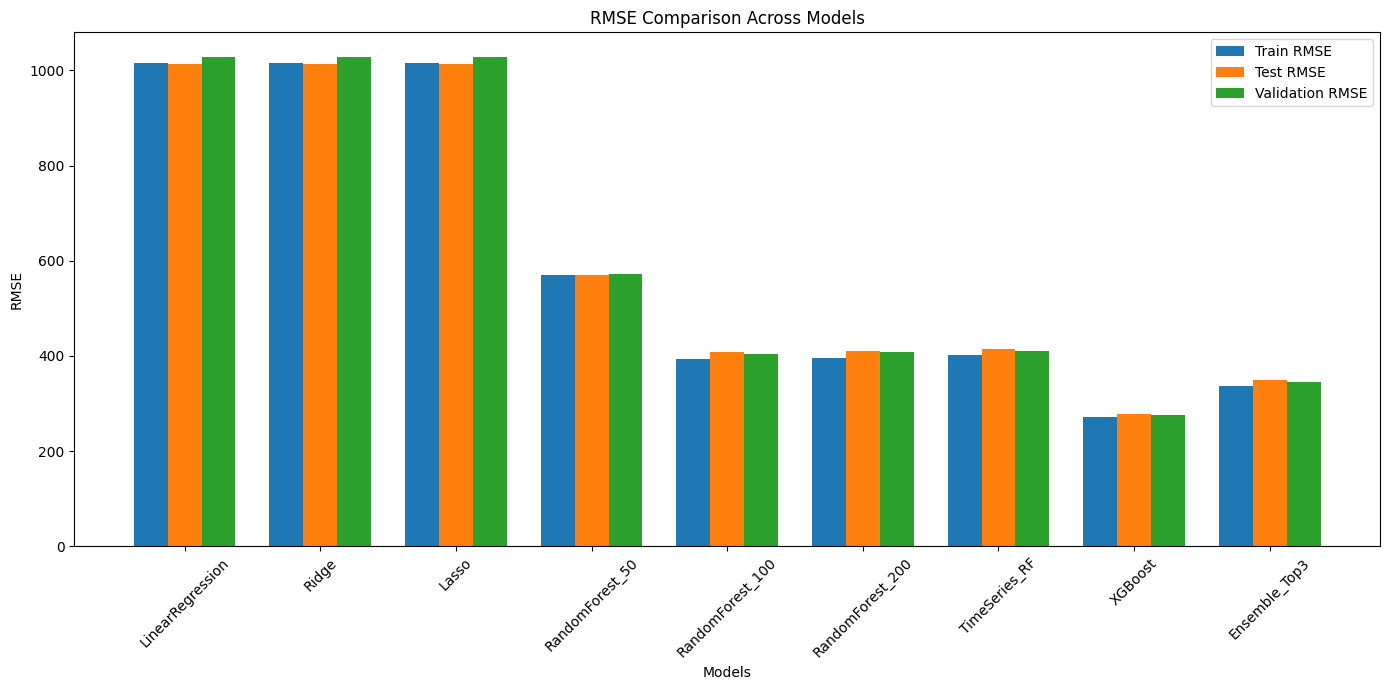

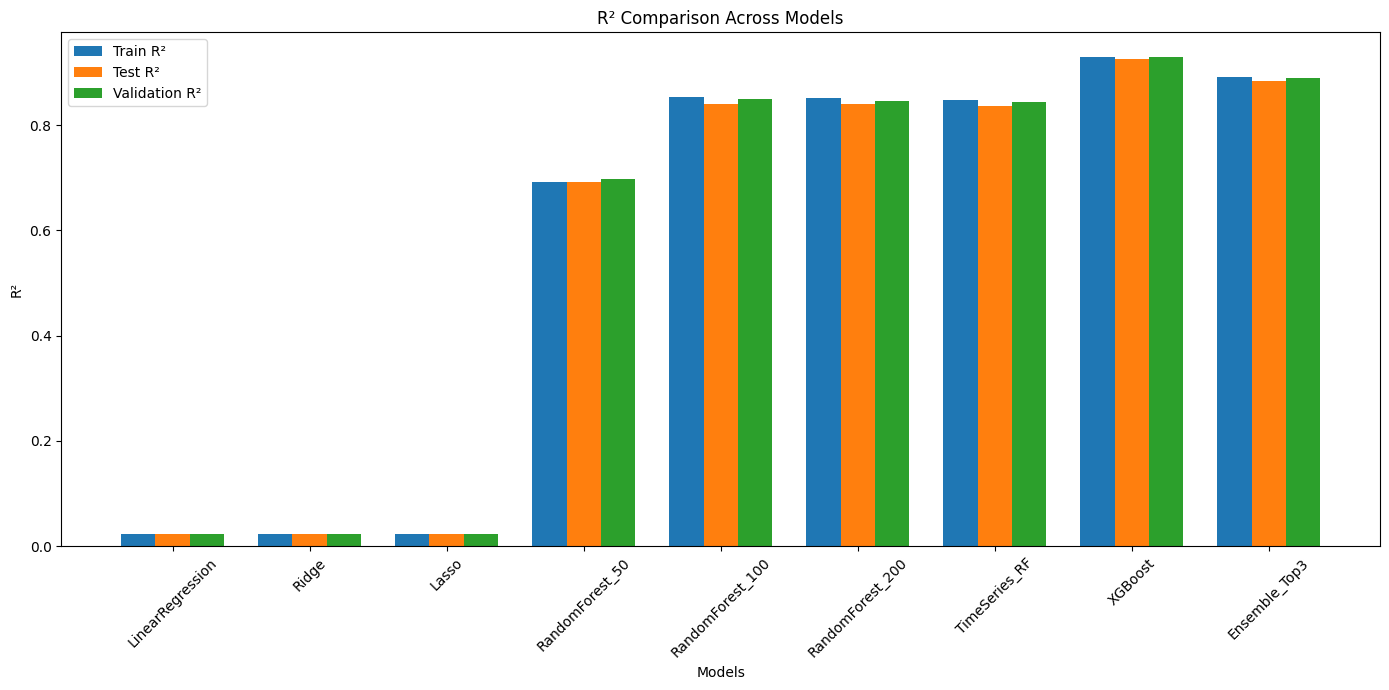

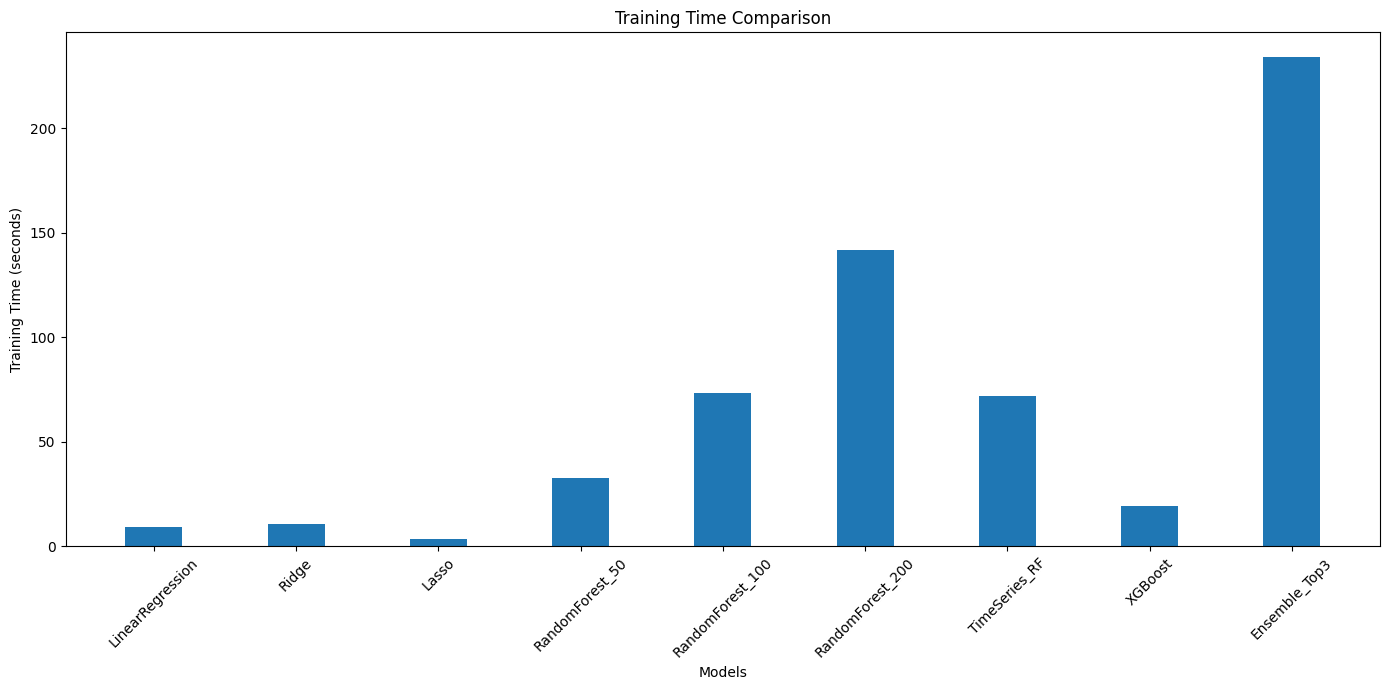

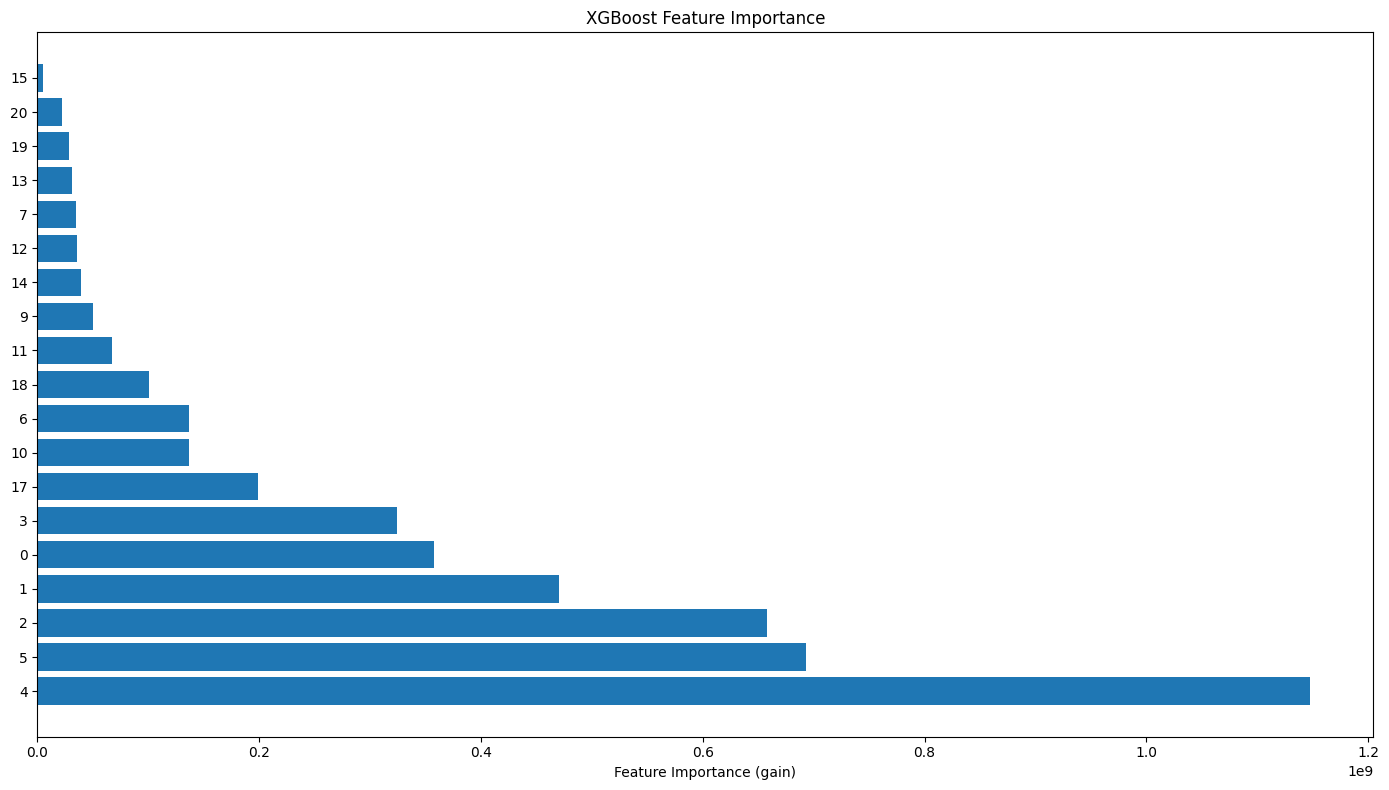

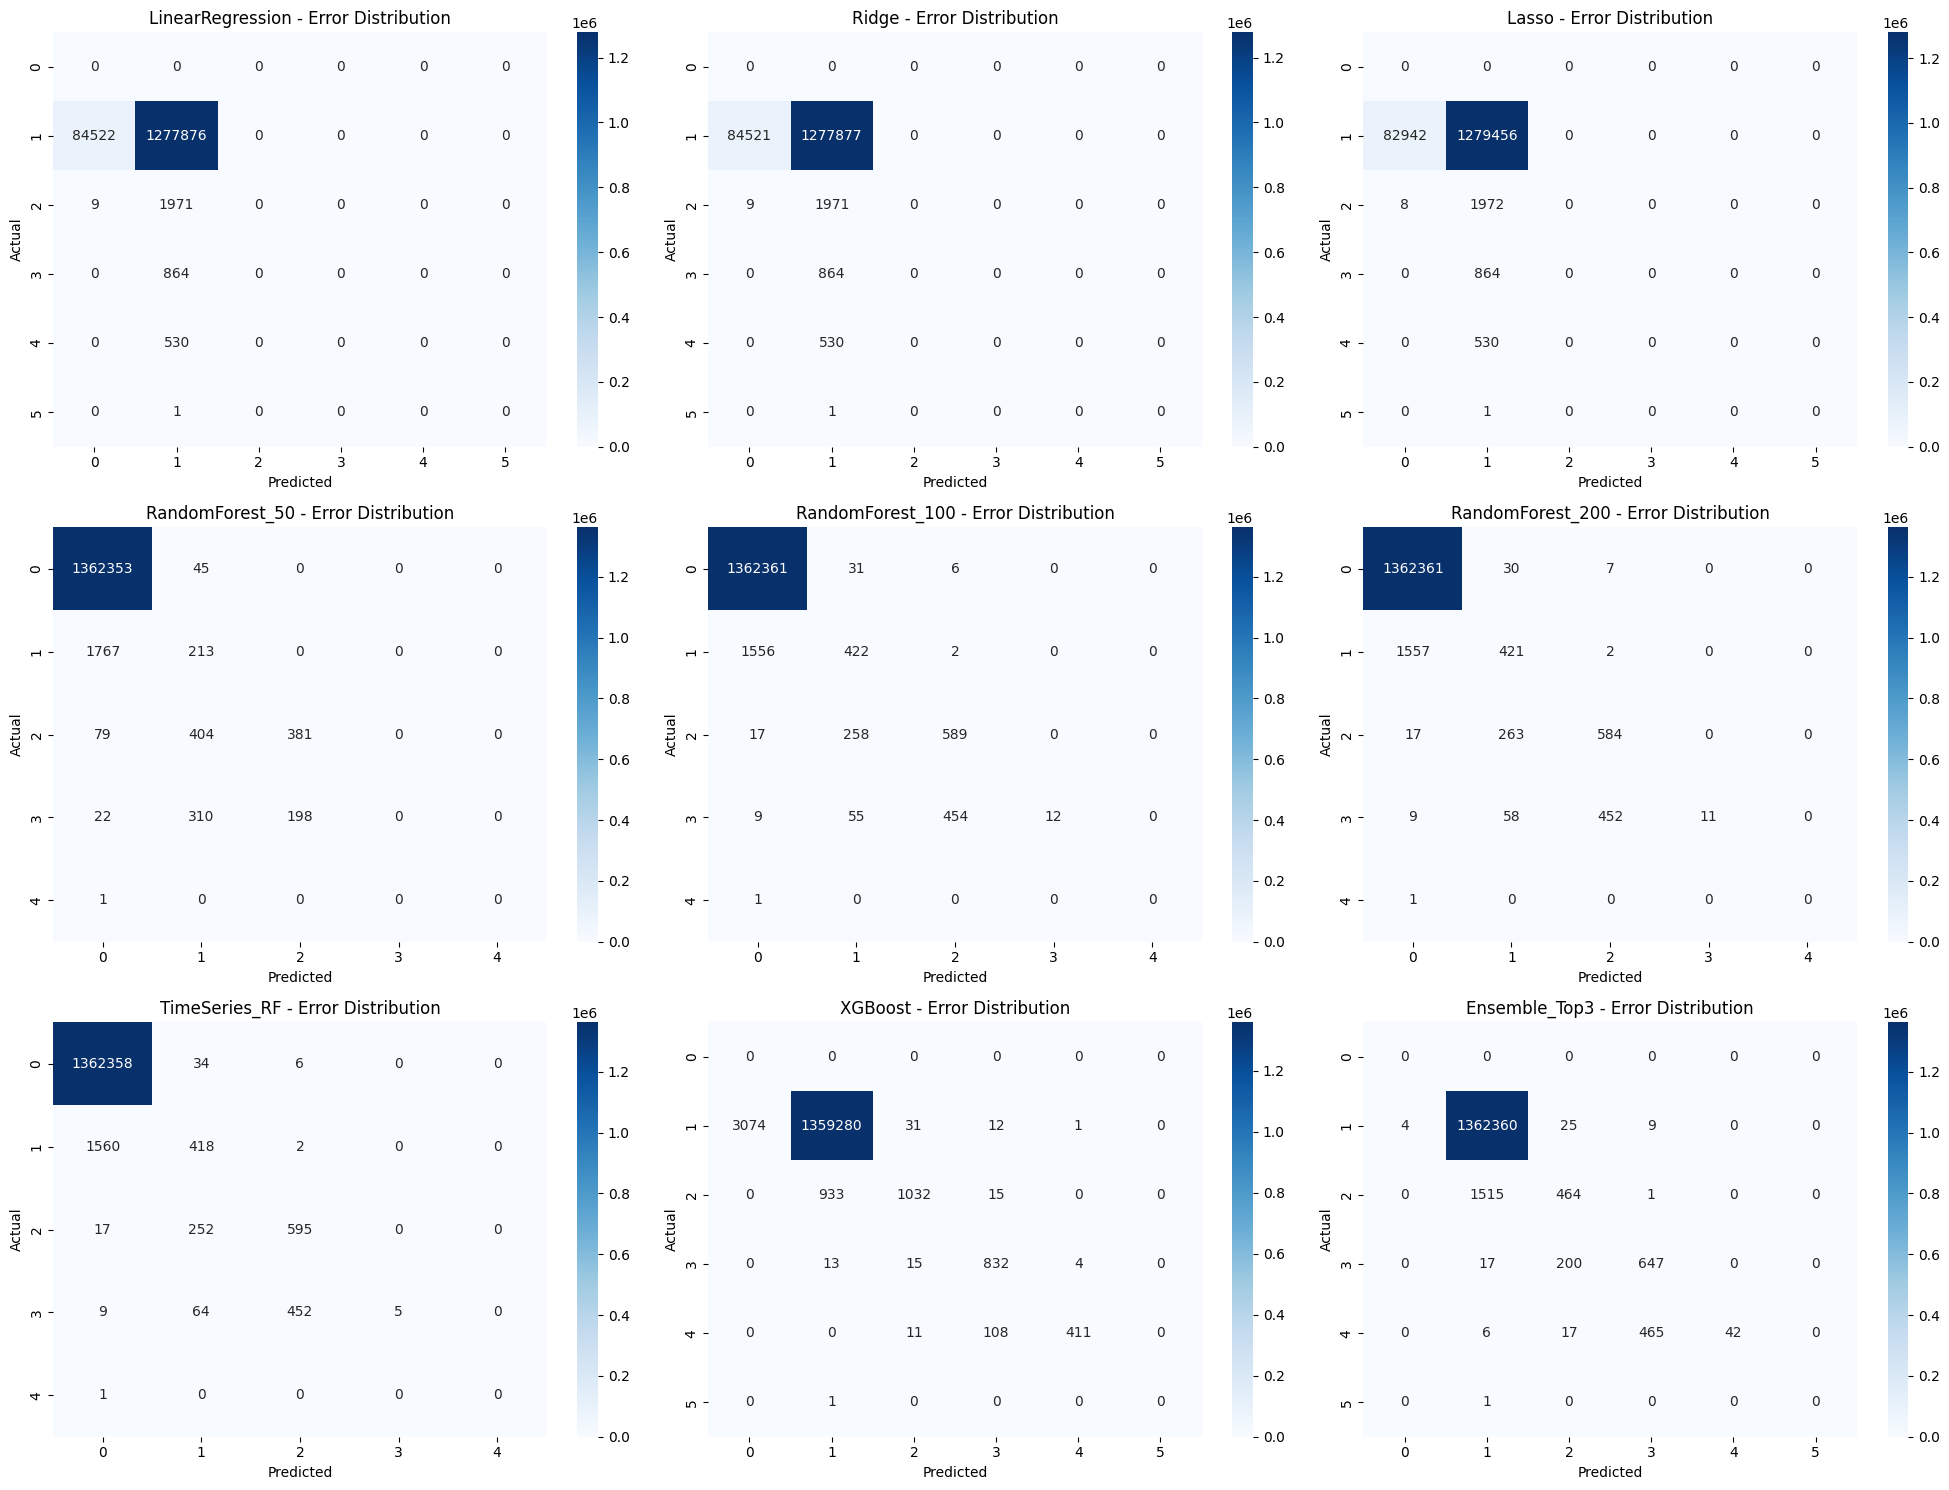

<Figure size 1200x600 with 0 Axes>

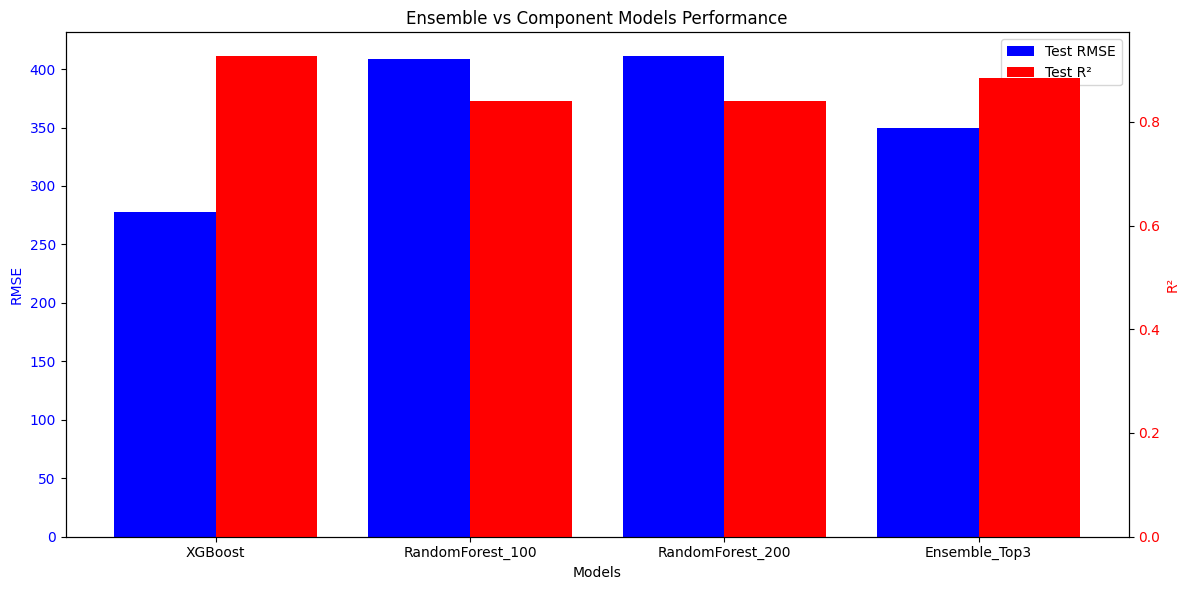

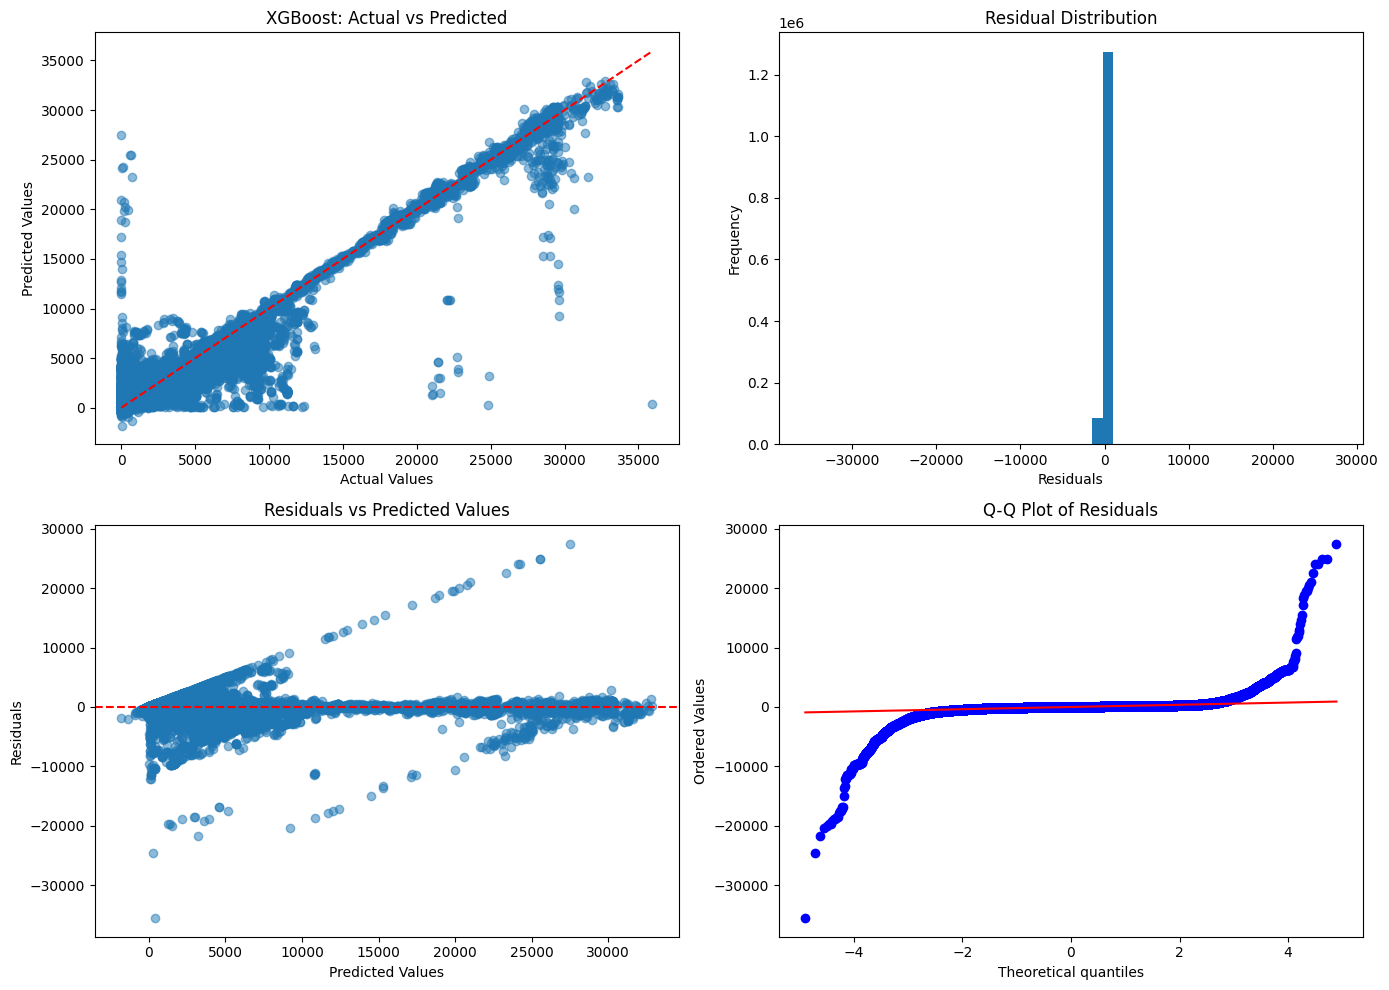

Visualizations saved to new/visualizations

Analysis completed successfully!


In [ ]:
if len(results) >= 3:
    try:
        print("\nCreating ensemble of best models...")

        sorted_models = sorted(results.items(), key=lambda x: x[1]["test_rmse"])
        top_3_models = [name for name, _ in sorted_models[:3]]

        print(f"Top 3 models for ensemble: {top_3_models}")

        ensemble_train_preds = np.zeros_like(y_train.to_pandas() if hasattr(y_train, 'to_pandas') else y_train)
        ensemble_test_preds = np.zeros_like(y_test.to_pandas() if hasattr(y_test, 'to_pandas') else y_test)
        ensemble_val_preds = np.zeros_like(y_val.to_pandas() if hasattr(y_val, 'to_pandas') else y_val)

        for model_name in top_3_models:
            train_preds = results[model_name]["predictions"]["train"]
            test_preds = results[model_name]["predictions"]["test"]
            val_preds = results[model_name]["predictions"]["val"]

            if hasattr(train_preds, 'to_pandas'):
                train_preds = train_preds.to_pandas().values
            if hasattr(test_preds, 'to_pandas'):
                test_preds = test_preds.to_pandas().values
            if hasattr(val_preds, 'to_pandas'):
                val_preds = val_preds.to_pandas().values

            ensemble_train_preds += train_preds
            ensemble_test_preds += test_preds
            ensemble_val_preds += val_preds

        ensemble_train_preds /= len(top_3_models)
        ensemble_test_preds /= len(top_3_models)
        ensemble_val_preds /= len(top_3_models)

        ensemble_train_rmse, ensemble_train_r2, ensemble_train_cm, _ = calculate_metrics(
            y_train.to_pandas() if hasattr(y_train, 'to_pandas') else y_train,
            ensemble_train_preds
        )
        ensemble_test_rmse, ensemble_test_r2, ensemble_test_cm, ensemble_cm_bins = calculate_metrics(
            y_test.to_pandas() if hasattr(y_test, 'to_pandas') else y_test,
            ensemble_test_preds
        )
        ensemble_val_rmse, ensemble_val_r2, ensemble_val_cm, _ = calculate_metrics(
            y_val.to_pandas() if hasattr(y_val, 'to_pandas') else y_val,
            ensemble_val_preds
        )

        results["Ensemble_Top3"] = {
            "train_rmse": ensemble_train_rmse,
            "train_r2": ensemble_train_r2,
            "test_rmse": ensemble_test_rmse,
            "test_r2": ensemble_test_r2,
            "val_rmse": ensemble_val_rmse,
            "val_r2": ensemble_val_r2,
            "training_time": sum([results[name]["training_time"] for name in top_3_models]),
            "component_models": top_3_models
        }

        confusion_matrices["Ensemble_Top3"] = (ensemble_test_cm, ensemble_cm_bins)

        print(f"  Ensemble Train RMSE: {ensemble_train_rmse:.4f}, R²: {ensemble_train_r2:.4f}")
        print(f"  Ensemble Test RMSE: {ensemble_test_rmse:.4f}, R²: {ensemble_test_r2:.4f}")
        print(f"  Ensemble Validation RMSE: {ensemble_val_rmse:.4f}, R²: {ensemble_val_r2:.4f}")

    except Exception as e:
        print(f"Error creating ensemble: {e}")

if results:
    best_model_name = min(results, key=lambda x: results[x]["test_rmse"])
    if best_model_name == "Ensemble_Top3":
        print("\nBest model is Ensemble of:", results[best_model_name]["component_models"])
        best_model = None  
    else:
        best_model = all_models[best_model_name]

    print(f"\nBest model: {best_model_name}")
    print(f"Test RMSE: {results[best_model_name]['test_rmse']:.4f}")
    print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")

    if best_model_name != "Ensemble_Top3":
        print(f"Training time: {results[best_model_name]['training_time']:.2f} seconds")

    if best_model is not None:
        model_dir = "new/models"
        os.makedirs(model_dir, exist_ok=True)

        if best_model_name == "XGBoost":
            try:
                best_model.save_model(f"{model_dir}/xgboost_model.model")
                print(f"Saved XGBoost model to {model_dir}/xgboost_model.model")
            except Exception as e:
                print(f"Could not save XGBoost model: {e}")
        else:
            try:
                joblib.dump(best_model, f"{model_dir}/{best_model_name}_cuml_model.joblib")
                print(f"Saved original cuML model to {model_dir}/{best_model_name}_cuml_model.joblib")
            except Exception as e:
                print(f"Could not save cuML model directly: {e}")

    try:
        joblib.dump(scaler, f"{model_dir}/scaler.joblib")
        print(f"Saved scaler to {model_dir}/scaler.joblib")
    except Exception as e:
        print(f"Could not save scaler: {e}")

    print("\nSummary of model results:")
    print("Model                Train RMSE    Test RMSE     Val RMSE     R²        Time(s)")
    print("-" * 80)
    for name, result in results.items():
        print(f"{name:<20} {result['train_rmse']:.4f}      {result['test_rmse']:.4f}      " +
              f"{result['val_rmse']:.4f}      {result['test_r2']:.4f}    {result.get('training_time', 0):.2f}")

    viz_dir = "new/visualizations"
    os.makedirs(viz_dir, exist_ok=True)

    plt.figure(figsize=(14, 7))
    model_names = list(results.keys())
    train_rmse = [results[name]['train_rmse'] for name in model_names]
    test_rmse = [results[name]['test_rmse'] for name in model_names]
    val_rmse = [results[name]['val_rmse'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.25

    plt.bar(x - width, train_rmse, width, label='Train RMSE')
    plt.bar(x, test_rmse, width, label='Test RMSE')
    plt.bar(x + width, val_rmse, width, label='Validation RMSE')

    plt.xlabel('Models')
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison Across Models')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{viz_dir}/rmse_comparison.png")
    plt.show()

    plt.figure(figsize=(14, 7))
    train_r2 = [results[name]['train_r2'] for name in model_names]
    test_r2 = [results[name]['test_r2'] for name in model_names]
    val_r2 = [results[name]['val_r2'] for name in model_names]

    plt.bar(x - width, train_r2, width, label='Train R²')
    plt.bar(x, test_r2, width, label='Test R²')
    plt.bar(x + width, val_r2, width, label='Validation R²')

    plt.xlabel('Models')
    plt.ylabel('R²')
    plt.title('R² Comparison Across Models')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{viz_dir}/r2_comparison.png")
    plt.show()

    plt.figure(figsize=(14, 7))
    times = [results[name].get('training_time', 0) for name in model_names]

    plt.bar(x, times, 0.4)
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.tight_layout()
    plt.savefig(f"{viz_dir}/training_time_comparison.png")
    plt.show()

    if "XGBoost" in all_models:
        plt.figure(figsize=(14, 8))
        xgb_model = all_models["XGBoost"]

        importance = xgb_model.get_score(importance_type='gain')
        features = list(importance.keys())
        scores = list(importance.values())
        indices = np.argsort(scores)[::-1]

        top_n = min(20, len(features))
        top_features = [features[i] for i in indices[:top_n]]
        top_scores = [scores[i] for i in indices[:top_n]]

        plt.barh(range(len(top_features)), top_scores, align='center')
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Feature Importance (gain)')
        plt.title('XGBoost Feature Importance')
        plt.tight_layout()
        plt.savefig(f"{viz_dir}/xgboost_feature_importance.png")
        plt.show()

    plt.figure(figsize=(20, 15))
    num_models = len(confusion_matrices)
    rows = (num_models + 2) // 3  

    for i, (name, (cm, bins)) in enumerate(confusion_matrices.items()):
        plt.subplot(rows, 3, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

        bin_labels = []
        for j in range(len(bins)-1):
            bin_labels.append(f'{bins[j]:.2f}-{bins[j+1]:.2f}')

        if len(bin_labels) == cm.shape[0]:
            plt.xticks(np.arange(len(bin_labels))+0.5, bin_labels, rotation=45)
            plt.yticks(np.arange(len(bin_labels))+0.5, bin_labels, rotation=0)

        plt.title(f'{name} - Error Distribution')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.savefig(f"{viz_dir}/model_confusion_matrices.png")
    plt.show()

    if "Ensemble_Top3" in results:
        plt.figure(figsize=(12, 6))

        component_models = results["Ensemble_Top3"]["component_models"]
        model_names = component_models + ["Ensemble_Top3"]

        test_rmse = [results[name]["test_rmse"] for name in model_names]
        test_r2 = [results[name]["test_r2"] for name in model_names]

        x = np.arange(len(model_names))

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.bar(x - 0.2, test_rmse, 0.4, color='blue', label='Test RMSE')
        ax1.set_xlabel('Models')
        ax1.set_ylabel('RMSE', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        ax2.bar(x + 0.2, test_r2, 0.4, color='red', label='Test R²')
        ax2.set_ylabel('R²', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.title('Ensemble vs Component Models Performance')
        plt.xticks(x, model_names, rotation=45)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.tight_layout()
        plt.savefig(f"{viz_dir}/ensemble_comparison.png")
        plt.show()

    if best_model_name != "Ensemble_Top3" and best_model_name in results:
        plt.figure(figsize=(14, 10))

        y_true = y_test.to_pandas().values if hasattr(y_test, 'to_pandas') else y_test
        y_pred = results[best_model_name]["predictions"]["test"]
        if hasattr(y_pred, 'to_pandas'):
            y_pred = y_pred.to_pandas().values

        plt.subplot(2, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{best_model_name}: Actual vs Predicted')

        plt.subplot(2, 2, 2)
        residuals = y_pred - y_true
        plt.hist(residuals, bins=50)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Residual Distribution')

        plt.subplot(2, 2, 3)
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Predicted Values')

        plt.subplot(2, 2, 4)
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot of Residuals')

        plt.tight_layout()
        plt.savefig(f"{viz_dir}/residual_analysis.png")
        plt.show()

    print(f"Visualizations saved to {viz_dir}")
else:
    print("No models were successfully trained for comparison")

print("\nAnalysis completed successfully!")

Performing detailed feature analysis for XGBoost model...
Top 10 most important features: ['VehicleLocationLatitude', 'VehicleLocationLongitude', 'DestinationLat', 'OriginLong', 'OriginLat', 'DestinationLong', 'Hour_sin', 'IsMorningPeak', 'Hour', 'Hour_cos']

Creating feature dependence plots...


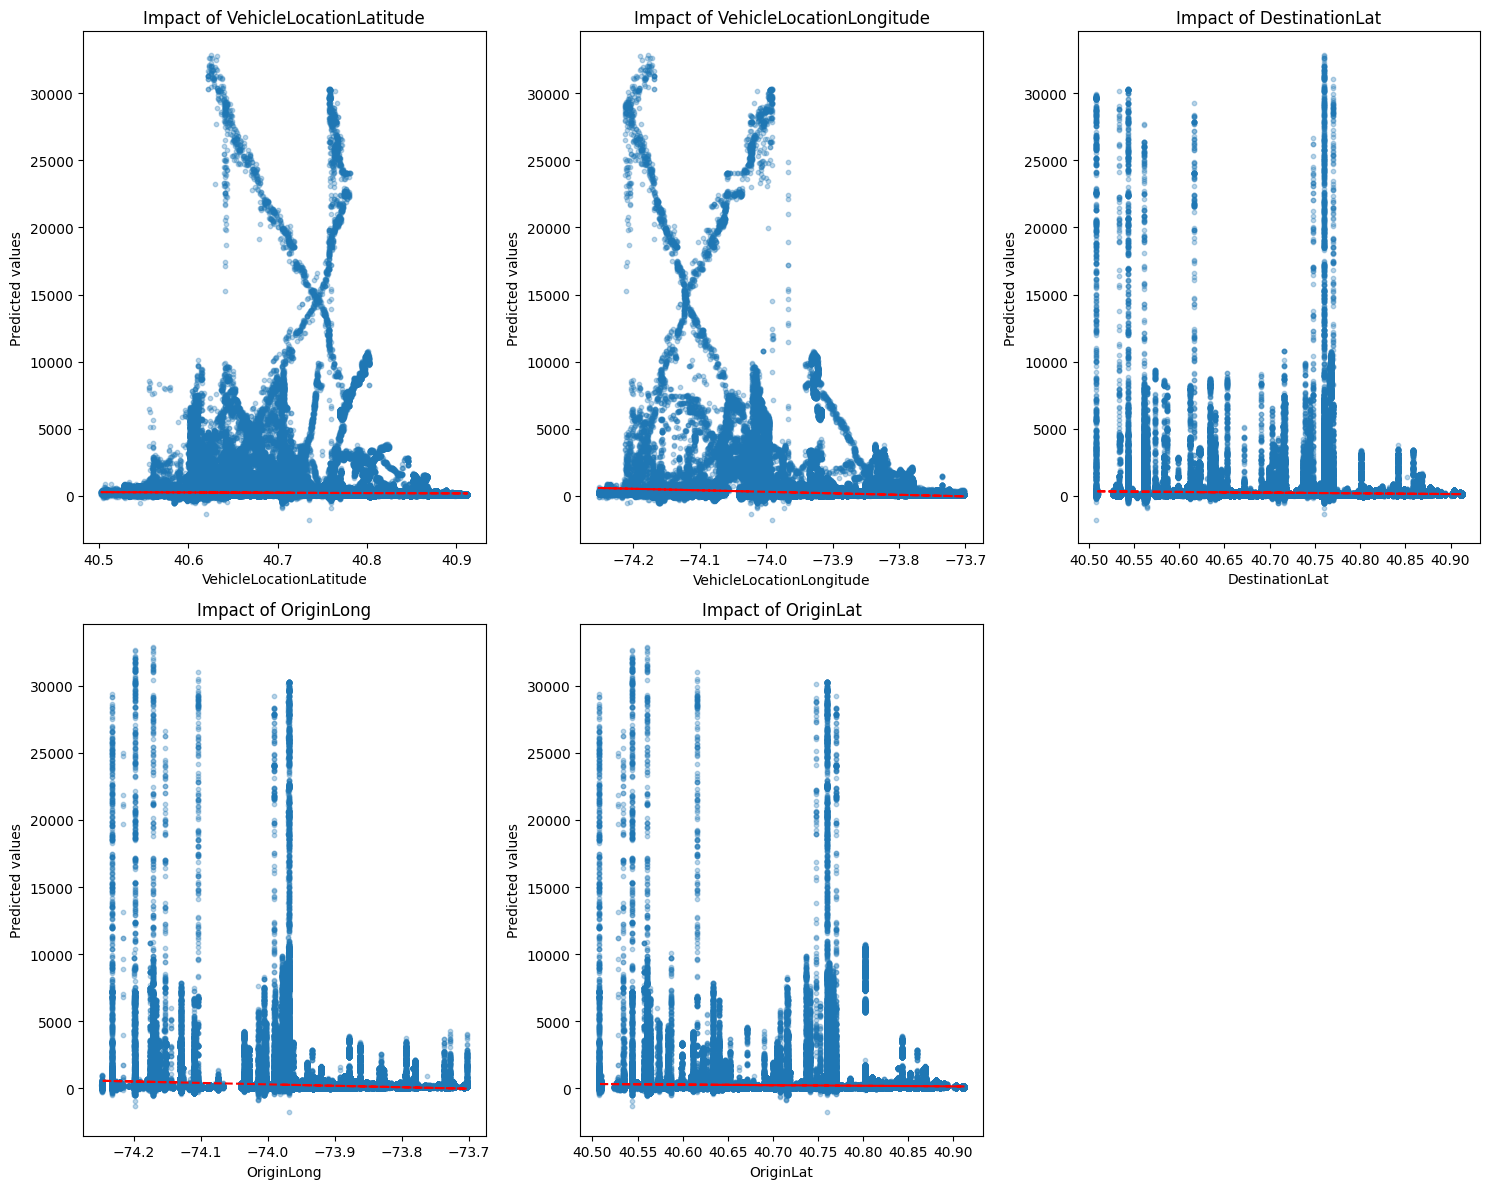

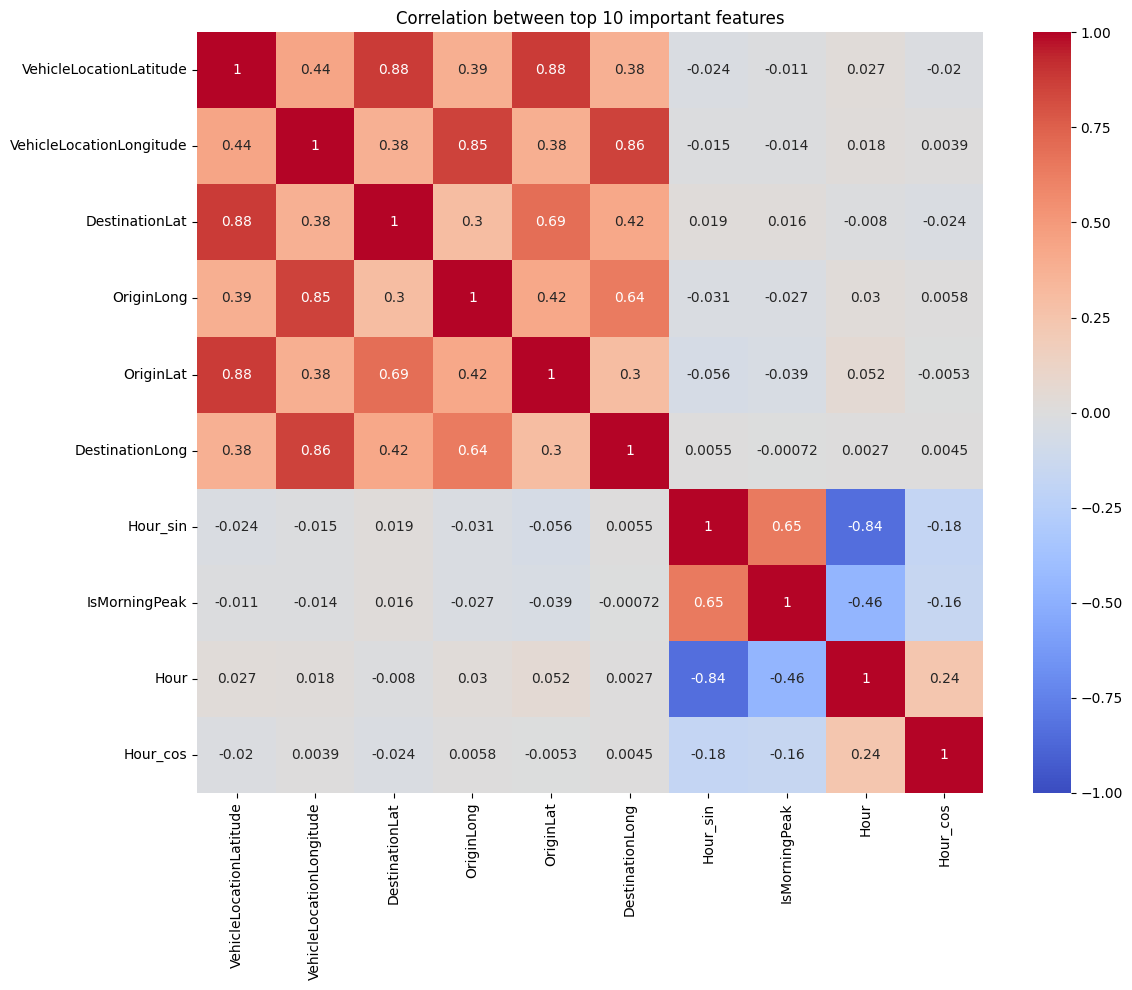

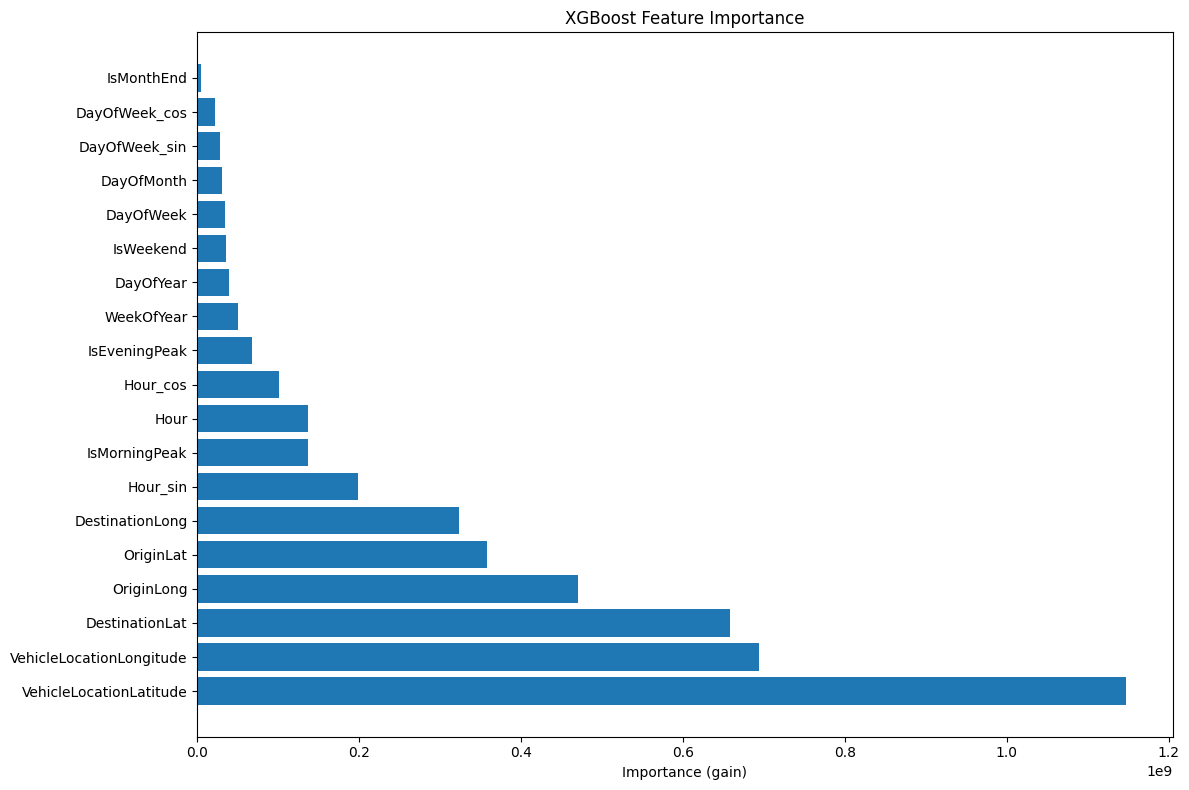

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler as SklearnScaler

if "XGBoost" in all_models:
    print("Performing detailed feature analysis for XGBoost model...")

    xgb_model = all_models["XGBoost"]
    importance = xgb_model.get_score(importance_type='gain')

    feature_indices = [int(f) for f in importance.keys()]
    feature_names = [available_features[i] for i in feature_indices]
    scores = list(importance.values())

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': scores,
        'Index': feature_indices
    }).sort_values('Importance', ascending=False)

    top_10_features = feature_importance['Feature'].head(10).tolist()
    top_10_indices = feature_importance['Index'].head(10).tolist()

    print(f"Top 10 most important features: {top_10_features}")

    print("\nCreating feature dependence plots...")

    X_test_pd = X_test.to_pandas() if hasattr(X_test, 'to_pandas') else pd.DataFrame(X_test)

    X_raw = df_clean[available_features].to_pandas() if hasattr(df_clean, 'to_pandas') else df_clean[available_features]
    sk_scaler = SklearnScaler()
    sk_scaler.fit(X_raw)


    X_test_original = pd.DataFrame(
        sk_scaler.inverse_transform(X_test_pd),
        columns=available_features
    )

    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(top_10_features[:5]):
        plt.subplot(2, 3, i+1)

        feature_values = X_test_original[feature].values
        predictions = results["XGBoost"]["predictions"]["test"]

        if hasattr(predictions, 'to_pandas'):
            predictions = predictions.to_pandas().values

        plt.scatter(feature_values, predictions, alpha=0.3, s=10)

        try:
            z = np.polyfit(feature_values, predictions, 1)
            p = np.poly1d(z)
            plt.plot(feature_values, p(feature_values), "r--")
        except:
            print(f"Could not fit trend line for {feature}")

        plt.xlabel(feature)
        plt.ylabel('Predicted values')
        plt.title(f'Impact of {feature}')

    plt.tight_layout()
    plt.savefig("new/visualizations/top_features_dependence.png")
    plt.show()

    plt.figure(figsize=(12, 10))

    corr_matrix = X_test_original[top_10_features].corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between top 10 important features')
    plt.tight_layout()
    plt.savefig("new/visualizations/feature_correlation.png")
    plt.show()

    plt.figure(figsize=(12, 8))
    sorted_idx = feature_importance.index
    pos = np.arange(len(feature_importance)) + 0.5
    plt.barh(pos, feature_importance['Importance'], align='center')
    plt.yticks(pos, feature_importance['Feature'])
    plt.xlabel('Importance (gain)')
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.savefig("new/visualizations/xgboost_feature_importance_detailed.png")
    plt.show()